## Trabalho II - Introdução ao Processamento Digital de Imagens

#### Desenvolvido por: Pedro João da Silva Júnior - 20190112416

### Importando bibliotecas

In [1]:
import math
import numpy as np 
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav

from PIL import Image


### Implementação da Transformada Discreta de Cosseno (DCT - Discrete Cosine Transform)

In [2]:
def dct_ck(k: int) -> float:
    return 0.7071067811865476 if k == 0 else 1.0


def dct_cos(k: int, n: int, N: int) -> float:
    return math.cos(2 * math.pi * k / (2 * N) * n + k * math.pi / (2 * N))


def dct(x: np.ndarray) -> np.ndarray:
    N = len(x)

    X = np.zeros(N, dtype=float)

    Ak = math.sqrt(2 / N)

    for k in range(N):
        sum = 0.0

        for n in range(N):
            sum += x[n] * dct_cos(k, n, N)

        X[k] = Ak * dct_ck(k) * sum

    return X


def idct(X: np.ndarray) -> np.ndarray:
    N = len(X)

    x = np.zeros(N, dtype=float)

    Ak = math.sqrt(2 / N)

    for n in range(N):
        sum = 0.0

        for k in range(N):
            sum += dct_ck(k) * X[k] * dct_cos(k, n, N)

        x[n] = Ak * sum

    return x


def dct2(x: np.ndarray) -> np.ndarray:
    X = np.zeros(x.shape, dtype=float)

    for i in range(x.shape[0]):
        X[i, :] = dct(x[i, :])

    for j in range(x.shape[1]):
        X[:, j] = dct(X[:, j])

    return X


def idct2(X: np.ndarray) -> np.ndarray:
    x = np.zeros(X.shape, dtype=float)

    for i in range(X.shape[0]):
        x[i, :] = idct(X[i, :])

    for j in range(X.shape[1]):
        x[:, j] = idct(x[:, j])

    return x


### DCT e IDCT de imagem

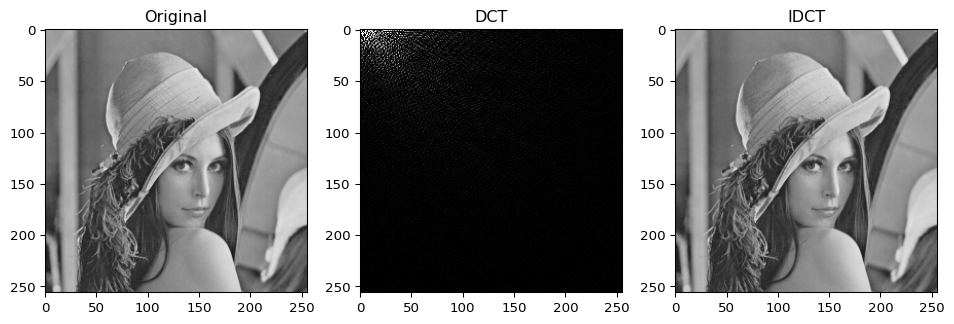

In [3]:
img = Image.open('lena256.png')
img_dct = dct2(np.array(img))
img_idct = idct2(img_dct)

_, ax = plt.subplots(1, 3, figsize=(12, 12), dpi=96)

ax[0].title.set_text('Original')
ax[0].imshow(img)
ax[1].title.set_text('DCT')
ax[1].imshow(Image.fromarray(img_dct))
ax[2].title.set_text('IDCT')
ax[2].imshow(Image.fromarray(img_idct))

plt.show()


### 1.1 - Exibindo DCT normalizada sem o nível DC da imagem

Valor númerico do nível DC: 31883.60937500001


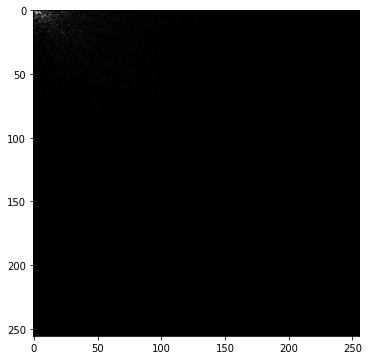

In [4]:
print(f'Valor númerico do nível DC: {img_dct[0, 0]}')

img_dct_norm = img_dct.copy()

# Zera o coeficiente DC
img_dct_norm[0, 0] = 0

# Obtém o módulo
img_dct_norm = np.abs(img_dct_norm)

img_dct_norm_min = img_dct_norm.min()
img_dct_norm_max = img_dct_norm.max()

# Expansão de histograma para [0-255]
img_dct_norm = (img_dct_norm - img_dct_norm_min) / \
    (img_dct_norm_max - img_dct_norm_min) * 255

plt.figure(figsize=(6, 6))
plt.imshow(Image.fromarray(img_dct_norm))
plt.show()


### 1.2 - Exibindo aproximação da imagem, preservando o coeficiente DC e os N coeficientes AC mais importantes da imagem

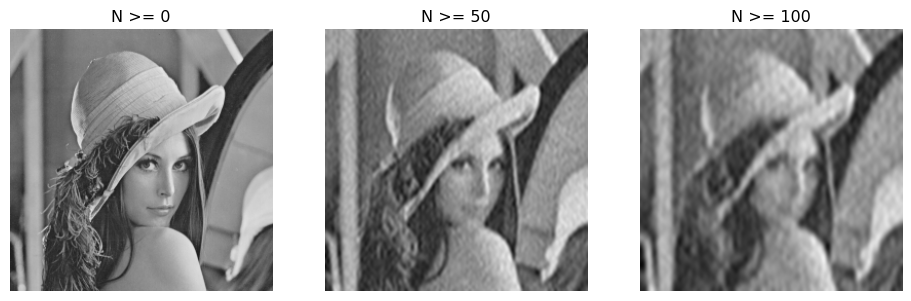

In [5]:
N = [0, 50, 100]


def kill_dct2_coeffs(dct: np.ndarray, n: int):
    h, w = dct.shape

    # RxC-1
    maxn = (h * w) - 1

    if n < 0 or n > maxn:
        raise ValueError(
            f'The \'n\' cannot be negative or greater than {maxn}')

    if n > dct[0, 0]:
        raise ValueError(
            'The \'n\' cannot be greater than the DC coefficient.')

    # Preserva os coeficientes cujo módulo é maior igual a 'n'
    for (y, x), c in np.ndenumerate(dct):
        if abs(c) < n:
            dct[y, x] = 0.0

    return dct


_, ax = plt.subplots(1, len(N), figsize=(12, 12), dpi=96)
for i, n in enumerate(N):
    res = kill_dct2_coeffs(img_dct.copy(), n=n)
    res_idct = idct2(res)
    
    ax[i].axis('off')
    ax[i].title.set_text(f'N >= {n}')
    ax[i].imshow(Image.fromarray(res_idct))

# plt.figure(figsize=(6, 6))
# plt.imshow(Image.fromarray(idct2(kill_dct_coeffs(img_dct.copy(), n=500))))

plt.show()


### Filtro Butterworth passa-baixa

In [6]:
def butterworth_low_pass(f: float, fc: float, n: int) -> float:
    return 1 / math.sqrt(1 + (f / fc)**(2 * n))


### 2 - Filtro Butterworth passa-baixa aplicado em imagem

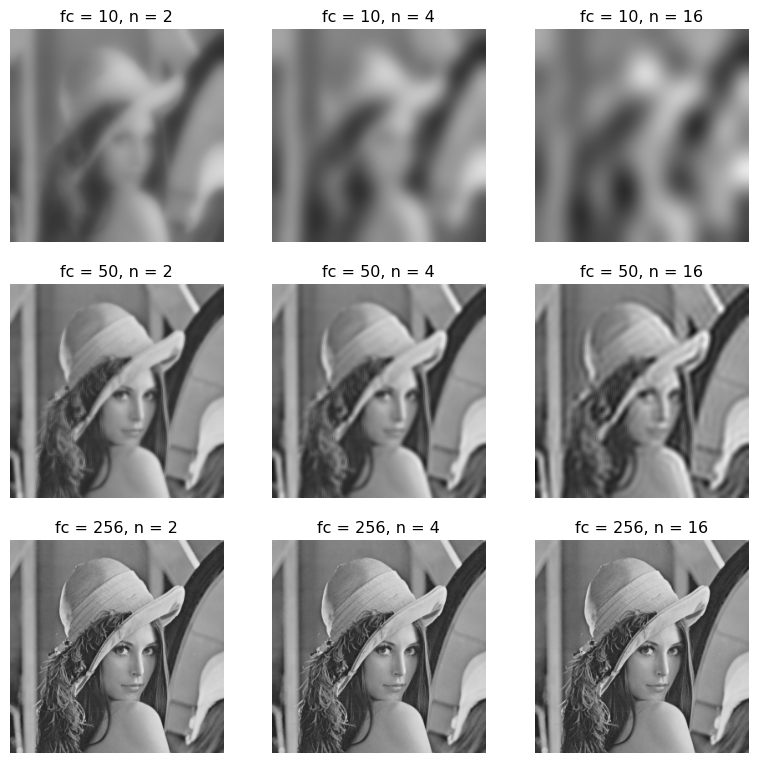

In [7]:
FC = [10, 50, 256]
N = [2, 4, 16]


def apply_dct2_lp_filter(dct: np.ndarray, fc: int, n: int):
    if fc == 0:
        raise ValueError('\'fc\' cannot be zero.')

    h, w = dct.shape

    # Centro da DCT
    cy, cx = (h * 0.5, w * 0.5)

    # Filtro com as dimensões da DCT
    f = np.zeros((h, w))

    for k in range(h):
        for l in range(w):
            # Calcula a distância euclidiana
            d = math.sqrt((cy - abs(k - cy))**2 + (cx - abs(l - cx))**2)
            f[k, l] = butterworth_low_pass(d, fc, n)

    return dct * f


plt.figure(figsize=(10, 10), dpi=96)
for i, fc in enumerate(FC):
    for j, n in enumerate(N):
        res = apply_dct2_lp_filter(img_dct.copy(), fc=fc, n=n)
        res_idct = idct2(res)

        plt.subplot(len(FC), len(N), i * len(N) + j + 1)
        plt.title(f'fc = {fc}, n = {n}')
        plt.axis('off')

        plt.imshow(Image.fromarray(res_idct))

# plt.figure(figsize=(6, 6))
# plt.imshow(Image.fromarray(
#     idct2(apply_dct2_lp_filter(img_dct.copy(), fc=40, n=2))))

plt.show()


### 3 - Filtro Butterworth passa-baixa aplicado em áudio

In [21]:
# Ler o arquivo de áudio
filename = 'MaisUmaSemana'
samplerate, signal = wav.read(f'{filename}.wav')

# DCT do sinal de áudio
signal_dct = dct(signal)

N = len(signal)
FA = samplerate
F1 = FA / (2 * (N - 1))

FC = 20_000 * F1  # Frequência de corte
FN = 2  # Ordem de filtro

# Aplica o filtro
signal_dct_filtered = signal_dct.copy()
for i, c in enumerate(signal_dct_filtered):
    signal_dct_filtered[i] = c * butterworth_low_pass(c * F1, FC, FN)

# IDCT do áudio
signal_idct = idct(signal_dct_filtered)

# Salva o áudio filtrado
wav.write(f'{filename} fc={FC:.0f} n={N}.wav',
          samplerate, signal_idct.astype(np.int16))

# _, axes = plt.subplots(1, 2, figsize=(14, 3.5))

# axes[0].title.set_text('DCT Original')
# axes[0].plot(signal_dct)
# axes[1].title.set_text(f'DCT Filtrada com FC = {FC:.0f} e N = {FN}')
# axes[1].plot(signal_dct_filtered)

# plt.show()


C:\Users\pedro\AppData\Local\Temp\ipykernel_7636\52577336.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, signal = wav.read(f'{filename}.wav')
